In [1]:
import numpy as np
from keras import backend as K
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.applications.imagenet_utils import preprocess_input
from keras.applications import VGG16
from keraspp import aicnn_subclass, aigen_subclass

Using TensorFlow backend.


In [2]:
class CNN(aicnn_subclass.CNN):
    def __init__(self, input_shape, nb_classes, n_dense=128, p_dropout=0.5, BN_flag=False, PretrainedModel=VGG16):
        self.n_dense = n_dense
        self.p_dropout = p_dropout
        self.PretrainedModel = PretrainedModel
        self.BN_flag = BN_flag
        super().__init__(nb_classes, input_shape) # 생성자에서 input_shpae를 사용해서 input_shape이 반드시 전달해야 함
        self.in_shape = input_shape
        
    def build_model(self):
        nb_classes = self.nb_classes
        input_shape = self.in_shape
        PretrainedModel = model.PretrainedModel
        
        base_model = PretrainedModel(weights='imagenet', include_top=False, input_shape=input_shape)
        x = base_model.input
        h = base_model.output
        z_cl = h
        h = model.topmodel(h)
        z_fl = h
        y = Dense(nb_classes, activation='softmax', name='preds')(h)
        
    def topmodel(self, h):
        BN_flag = self.BN_flag
        
        n_dense = self.n_dense
        p_dropout = self.p_dropout
        h = GlobalAveragePooling2D()(h)
        h = Dense(n_dense, activation='relu')(h)
        if BN_flag:
            h = BatchNormalization()(h)
        else:
            h = Dropout(p_dropout)(h)
            
        return h

In [3]:
class DataSet(aicnn_subclass.DataSet):
    def __init__(self, X, y, nb_classes, n_channels=3, scaling=True, test_size=0.2, random_state=0):
        self.n_channels = n_channels
        super().__init__(X, y, nb_classes, scaling=scaling, test_size=test_size, random_state=random_state)
        
    def add_channles(self):
        n_channels = self.n_channels
        if n_channles == 1:
            super().add_channels()
        else:
            X = self.X
            if X.ndim < 4:
                N, img_rows, img_cols = X.shape
                if K.image_dim_ordering() == 'th':
                    X = X.reshape(X.shape[0], 1, img_rows, img_cols)
                    X = np.concateneate([X, X, X], axis=1)
                    input_shape = (n_channels, img_rows, img_cols)
                else:
                    X = X.reshape(X.shape[0], img_rows, img_cols, 1)
                    X = np.concatenate([X, X, X], axis=3)
                    input_shape = (img_rows, img_cols, n_channels)
            else:
                if K.image_dim_ordering() == 'th':
                    N, Ch, img_rows, img_cols = X.shape
                    if Ch == 1:
                        X = np.concatenate([X, X, X], axis=1)
                    input_shape = (n_channels, img_rows, img_cols)
                else:
                    N, img_rows, img_cols, Ch = X.shape
                    if Ch == 1:
                        X = np.concatenate([X, X, X], axis=3)
                    input_shape = (img_rows, img_cols, n_channels)
            X = preprocess_input(x)
            self.X = X
            self.input_shape = input_shape

In [4]:
class Machine_Generator(aigen_subclass.Machine_Generator):
    def __init__(self, X, y, nb_classes=2, steps_per_epoch=10, n_dense=128, p_dropout=0.5, BN_flag=False,
                scaling=False, PretrainedModel=VGG16, fig=True, gen_param_dict=None):
        self.scaling = scaling
        self.n_dense = n_dense
        self.p_dropout = p_dropout
        self.BN_flag = BN_flag
        self.PretrainedModel = PretrainedModel
        super().__init__(X, y, nb_classes=nb_classes, steps_per_epoch=steps_per_epoch, 
                         fig=fig, gen_param_dict=gen_param_dict)
    
    def set_data(self, X, y):
        nb_classes = self.nb_classes
        scaling = self.scaling
        self.data = DataSet(X, y, nb_classes, n_channels=3, scaling=scaling)
        
    def set_model(self):
        data = self.data
        nb_classes = self.nb_classes
        n_dense = self.n_dense
        p_dropout = self.p_dropout
        BN_flag = self.BN_flag
        PretrainedModel = self.PretrainedModel
        
        self.model = CNN(data.input_shape, nb_classes, n_dense=n_dense, p_dropout=p_dropout,
                        BN_flag=BN_flag, PretrainedModel=PretrainedModel)

# What does "sample", "batch", "epoch" mean?
Below are some common definitions that are necessary to know and understand to correctly utilize Keras:

* Sample: one element of a dataset.
    * Example: one image is a sample in a convolutional network
    * Example: one audio file is a sample for a speech recognition model
* Batch: a set of N samples. The samples in a batch are processed independently, in parallel. If training, a batch results in only one update to the model.
* A batch generally approximates the distribution of the input data better than a single input. The larger the batch, the better the approximation; however, it is also true that the batch will take longer to process and will still result in only one update. For inference (evaluate/predict), it is recommended to pick a batch size that is as large as you can afford without going out of memory (since larger batches will usually result in faster evaluation/prediction).
* Epoch: an arbitrary cutoff, generally defined as "one pass over the entire dataset", used to separate training into distinct phases, which is useful for logging and periodic evaluation.
* When using validation_data or validation_split with the fit method of Keras models, evaluation will be run at the end of every epoch.
* Within Keras, there is the ability to add callbacks specifically designed to be run at the end of an epoch. Examples of these are learning rate changes and model checkpointing (saving).

In [5]:
from sklearn import model_selection
from keras import datasets
import keras
assert keras.backend.image_data_format() == 'channels_last'

#from keraspp import aiprt_subclass

In [6]:
class Machine(Machine_Generator):
    def __init__(self):
        (x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
        _, X, _, y = model_selection.train_test_split(x_train, y_train, test_size=0.02)
        X = X.astype(float)
        super().__init__(X, y, nb_classes=10)

In [7]:
def main():
    m = Machine()
    m.run()

(800, 32, 32, 3) (800, 1)
X_train shape: (800, 32, 32, 3)
800 train samples
200 test samples
Train on 800 samples, validate on 200 samples
Epoch 1/100
800/800 [==============================] - 2s 2ms/step - loss: 128.4902 - accuracy: 0.1050 - val_loss: 5.1050 - val_accuracy: 0.1250
Epoch 2/100
800/800 [==============================] - 0s 214us/step - loss: 3.3882 - accuracy: 0.1213 - val_loss: 2.2539 - val_accuracy: 0.0950
Epoch 3/100
800/800 [==============================] - 0s 213us/step - loss: 2.3316 - accuracy: 0.1100 - val_loss: 2.3977 - val_accuracy: 0.0950
Epoch 4/100
800/800 [==============================] - 0s 208us/step - loss: 2.2884 - accuracy: 0.1287 - val_loss: 2.2733 - val_accuracy: 0.0950
Epoch 5/100
800/800 [==============================] - 0s 207us/step - loss: 2.2511 - accuracy: 0.1275 - val_loss: 2.2656 - val_accuracy: 0.1150
Epoch 6/100
800/800 [==============================] - 0s 207us/step - loss: 2.2552 - accuracy: 0.1213 - val_loss: 2.2763 - val_accuracy

800/800 [==============================] - 0s 210us/step - loss: 0.2665 - accuracy: 0.9175 - val_loss: 3.0338 - val_accuracy: 0.3450
Epoch 57/100
800/800 [==============================] - 0s 215us/step - loss: 0.2346 - accuracy: 0.9137 - val_loss: 3.3668 - val_accuracy: 0.4000
Epoch 58/100
800/800 [==============================] - 0s 215us/step - loss: 0.1802 - accuracy: 0.9388 - val_loss: 3.0078 - val_accuracy: 0.3800
Epoch 59/100
800/800 [==============================] - 0s 208us/step - loss: 0.1488 - accuracy: 0.9550 - val_loss: 3.8871 - val_accuracy: 0.3900
Epoch 60/100
800/800 [==============================] - 0s 208us/step - loss: 0.2730 - accuracy: 0.9237 - val_loss: 3.5757 - val_accuracy: 0.2750
Epoch 61/100
800/800 [==============================] - 0s 228us/step - loss: 16.9722 - accuracy: 0.3762 - val_loss: 3.6638 - val_accuracy: 0.2150
Epoch 62/100
800/800 [==============================] - 0s 232us/step - loss: 0.9713 - accuracy: 0.7425 - val_loss: 2.5122 - val_accurac

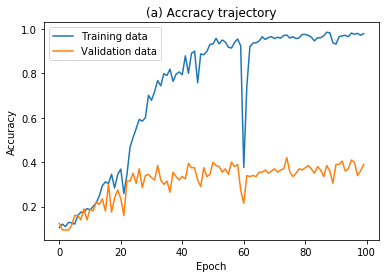

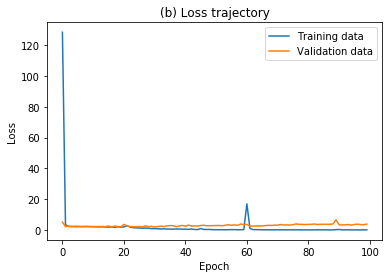

In [8]:
main()